# Introduction

[CheckM2](https://doi.org/10.1038/s41592-023-01940-w) is an alternative method to BUSCO to assess bin quality that uses universally trained machine learning models to predict Completeness and Contamination indipendently of taxonomic lineage. This eliminates the need to have 3 separate databases and run 3 different jobs, like in BUSCO, one for each domain of life. After installing using:  
```conda create -n checkm2 -c bioconda -c conda-forge checkm2```

After installation, to test working:  
```checkm2 testrun```  

In this notebook:
- Setup and execution of the CheckM2 quality assessment on the Euler Cluster.
- Visualize the results in a comparable format to BUSCO
- Directly compare the yield after filtering

## Setup on Euler

CheckM2 needs a folder containing all MAGs and will not work with the nesting by sample that is currently imposed in sample_data for BUSCO evaluation. The MAGs can be copied from sample_data subfolders and save in the \$INPUT_DIR with a simple loop.
```
mkdir -p /cluster/scratch/$USER/CheckM2_input

for d in /cluster/scratch/$USER/sample_data/*/; do
    cp -r "$d" /cluster/scratch/$USER/CheckM2_input/
done
```


CheckM2 has been run as a .slurms.sh submitted to the computing node. Because it will use DIAMOND for gene prediction, multiple threads (60) have been allocated to speed up the process. Two non-default arguments have been used:  
``` --force``` <- simply overwrites the output (used to avoid manually deleting the directory manually after each failed attempt)  
``` -x fa``` <- specifies .fa file format of the MAGS (will give an error otherwise)

CheckM2 will generate a quality_report.tsv to be used to answer the question. Additionally predicted protein folder is also provided that could be used for functional annotation (KEGG) or to generates orthogroups (OrthoFinder)

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold; text-align:center;">
  Output provided
</div>

```
#!/bin/bash
#SBATCH --job-name=CheckM2_Predict
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=20
#SBATCH --mem-per-cpu=6G
#SBATCH --time=48:00:00
#SBATCH --output=/cluster/home/%u/applied_bioinformatics/01_logs/%x_%j_out.log
#SBATCH --error=/cluster/home/%u/applied_bioinformatics/01_logs/%x_%j_err.log

source /cluster/home/$USER/miniconda3/etc/profile.d/conda.sh
conda activate checkm2

INPUT_DIR=/cluster/scratch/$USER/CheckM2_input
OUTPUT_DIR=/cluster/scratch/$USER/03_artifacts/CheckM2

mkdir -p $OUTPUT_DIR

checkm2 predict --threads 60 --input $INPUT_DIR --output-directory $OUTPUT_DIR --force -x fa

echo "saving a copy of the CheckM results to /cluster/home/$USER/applied_bioinformatics/03_Artifacts_Zipped/"
# compress busco results and send to home directory
DATE=$(date +%Y%m%d)
tar -czf /cluster/home/$USER/applied_bioinformatics/03_Artifacts_Zipped/CheckM2_results_$DATE.tar.gz -C /cluster/scratch/$USER/03_artifacts CheckM2
echo "CheckM results archived successfully."

conda deactivate 
```

## Visualization
Due to the difference in computing quality metrics, their distribution in comparison to BUSCO could also be of interest. To visualize this, the same approach as used in the previous notebook is used.
- save completeness and contamination as axis variables
- use the same scatter_hist function used for BUSCO
- plot

In [1]:
import pandas as pd

CheckM2 = pd.read_csv('data/processed/02-1_CheckM2/quality_report.tsv', sep = '\t')
CheckM2.head(3)

,Name,Completeness,Contamination,Completeness_Model_Used,Translation_Table_Used,Coding_Density,Contig_N50,Average_Gene_Length,Genome_Size,GC_Content,Total_Coding_Sequences,Total_Contigs,Max_Contig_Length,Additional_Notes
0,001fda80-9c80-4be8-9861-4852262c7065,26.76,1.02,Neural Network (Specific Model),11,0.873,58678,275.752768,768649,0.35,813,14,84346,NaN
1,009d5f9a-be92-4328-b5ad-68d282a94e3b,99.47,4.32,Neural Network (Specific Model),11,0.864,545843,306.325145,2206322,0.45,2076,5,993236,NaN
2,00c782c9-f243-467f-b752-3ff671081218,5.38,0.02,Neural Network (Specific Model),11,0.000,7540,204.754386,201303,0.34,285,29,35984,NaN


In [2]:
x_checkm = CheckM2['Completeness']
y_checkm = CheckM2['Contamination']

In [3]:
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

def scatter_hist(x, y, ax, ax_histx, ax_histy, color_type):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax_histx.set_xlim(0, 100)
    ax_histy.set_ylim(0, 100)

    ax.scatter(x, y, s=10, alpha=0.3, color = color_type)

    ax.plot([50,100], [10,10], '--', linewidth=2, color='green')
    ax.plot([50,50], [0,10], '--', linewidth=2, color='green')

    bins = np.arange(0, 101, 5)

    ax_histx.hist(x, bins=bins, color = color_type, alpha=0.7, histtype = 'step')
    ax_histy.hist(y, bins = bins, orientation ='horizontal', color = color_type, alpha=0.7, histtype = 'step')
    ax_histx.set_title('Distribution of Contamination across Completeness (CheckM2)')
    ax.set_xlabel('Completness (%)')
    ax.set_ylabel('Contamination (%)')

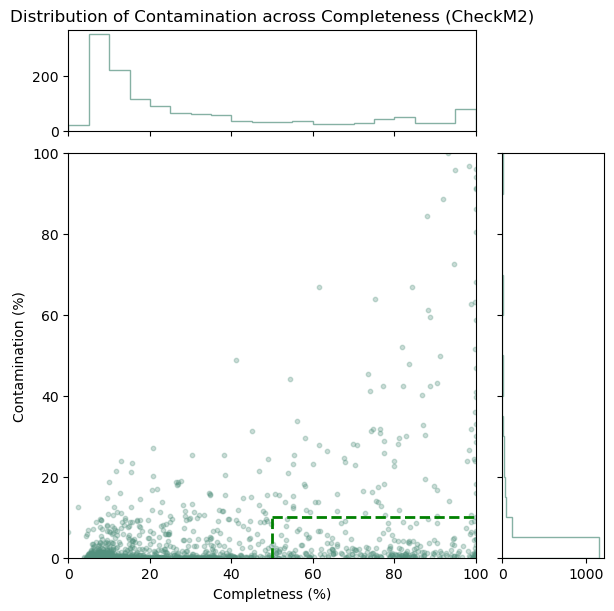

In [4]:
layout = [
    ['histx1', '.',],
    ['scatter1', 'histy1']
]

fig, axs = plt.subplot_mosaic(
    layout,
    figsize=(6, 6),
    width_ratios=[4,1],
    height_ratios=[1,4],
    layout='constrained'
)

# Bacteria
scatter_hist( # Illumina
    x=x_checkm,
    y=y_checkm,
    ax=axs['scatter1'],
    ax_histx=axs['histx1'],
    ax_histy=axs['histy1'],
    color_type='#53917E'
)

As can be seen from the visualization, the pattern of the data points is substancially different from BUSCO by not following hyperbolic trend. Instead, the top left quadrant of the scatter is empty. This is expected as the machine learning model does not work using a reference db that in our case would possibly categorize different domain MAGs as high contaminated.

## Direct comparison with BUSCO
To Understand how CheckM2 performed against BUSCO, the result of the filtering are compared side by side.

In [5]:
# Function also reused from the BUSCO notebook
def prepare_and_filter_busco(busco_df, prefix=None, min_Completeness=50, max_Contamination=10):
    df = busco_df.copy()
    
    # Filter by prefix if given
    if prefix is not None:
        df = df[df['sample_id'].str.startswith(prefix)]
    
    # Convert to float
    df['Completeness'] = df['Completeness'].astype(float)
    df['Contamination'] = df['Contamination'].astype(float)
    
    # Drop NaNs
    df = df.dropna(subset=['Completeness', 'Contamination'])
    
    # Apply filtering thresholds
    df = df[(df['Completeness'] >= min_Completeness) & (df['Contamination'] < max_Contamination)]
    
    return df


In [6]:
checkm_filtered = prepare_and_filter_busco(CheckM2)

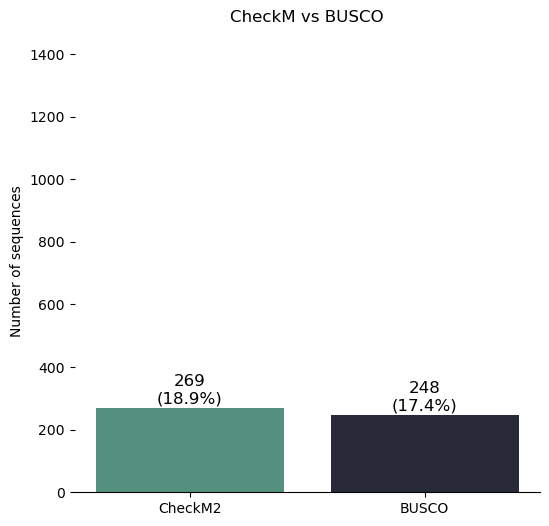

In [7]:
import matplotlib.pyplot as plt

# Values
counts = [len(checkm_filtered), 248]
labels = ['CheckM2', 'BUSCO']
total = 1426
percentages = [c / total * 100 for c in counts]

# Plot
plt.figure(figsize=(6,6))
bars = plt.bar(labels, counts, color=['#53917E', '#272838'])

# Add percentage labels above each bar
# Add percentage and count labels above each bar
for i, bar in enumerate(bars):
    height = int(bar.get_height())
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        f"{height}\n({percentages[i]:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=12
    )
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel('Number of sequences')
plt.title('CheckM vs BUSCO')
plt.ylim(0, total + 50)
plt.show()


Number of total MAGs retreived after filtering. Percentage values indicates portion retained from the initial 1426 MAGs dataset.
CheckM2 assigned quality scores above the threshold in 21 instances more than BUSCO.